# Breast Cancer Detection
In this notebook, we will use Neural Networks to determine whether a breast's ultrasound is a benign, a malignant or a normal image.

# Summary
- Data Analysis
- Sequential Conv2D model
- Xception
- ResNet50V2

# Library

In [13]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

# Neural networks
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# Data

In [14]:
PATH = "./data/"

In [15]:
images_benign = glob.glob(PATH + "/benign/*")
images_malignant = glob.glob(PATH + "/malignant/*")
images_normal = glob.glob(PATH + "/normal/*")

# Showing samples of the images

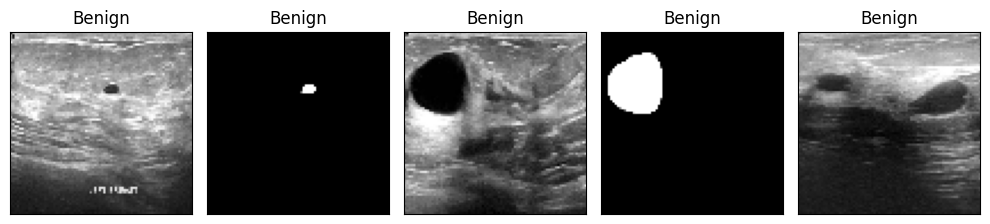

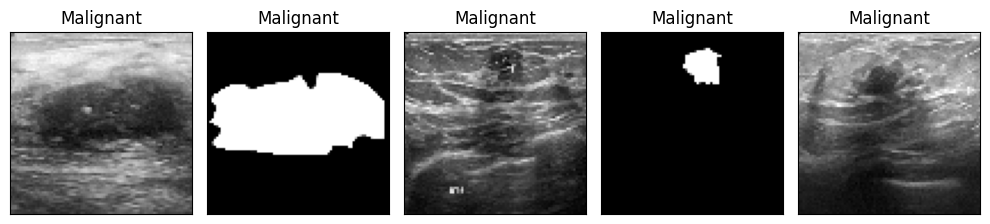

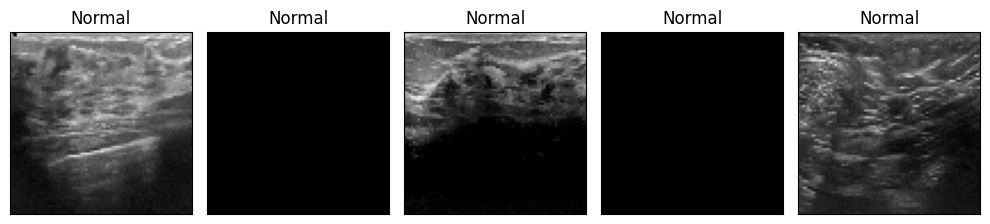

In [16]:
def show_images(list, listname):
    fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 10), subplot_kw = {'xticks':[], 'yticks':[]})
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(list[i])
        img = cv2.resize(img, (80, 80))
        ax.imshow(img)
        ax.set_title(listname)
    fig.tight_layout()
    plt.show()
    
show_images(images_benign, "Benign")
show_images(images_malignant, "Malignant")
show_images(images_normal, "Normal")

# Generating an X and a y model

In [17]:
def add_to_X_and_y(X, y, list, listname):
    for i in list:
        img = cv2.imread(i)
        scalled_raw_img = cv2.resize(img, (80, 80))/255.0
        X.append(scalled_raw_img)
        y.append(listname)
    return X, y

In [18]:
X, y = [], []
X, y = add_to_X_and_y(X, y, images_benign, 0)
X, y = add_to_X_and_y(X, y, images_malignant, 1)
X, y = add_to_X_and_y(X, y, images_normal, 2)
X, y = np.array(X), np.array(y)

In [19]:
y = tf.keras.utils.to_categorical(y, num_classes=3)

In [20]:
target_name = {'Benign': 0, 'Malignant': 1, 'Normal': 2}

# Generating X_train, X_val & others

In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42)

# Sequential Conv2D model

## Model

In [39]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 39, 39, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 18, 18, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 16384)            

In [52]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs=30,
    validation_data = (X_val, y_val),
)

Epoch 1/30
4/4 [==============================] - 4s 835ms/step - loss: 0.0082 - accuracy: 0.9968 - val_loss: 3.3704 - val_accuracy: 0.7089
Epoch 2/30
4/4 [==============================] - 3s 823ms/step - loss: 0.0051 - accuracy: 0.9968 - val_loss: 3.1437 - val_accuracy: 0.7247
Epoch 3/30
4/4 [==============================] - 3s 834ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 2.9874 - val_accuracy: 0.7532
Epoch 4/30
4/4 [==============================] - 3s 829ms/step - loss: 0.0037 - accuracy: 0.9979 - val_loss: 2.8932 - val_accuracy: 0.7373
Epoch 5/30
4/4 [==============================] - 3s 827ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 2.8771 - val_accuracy: 0.7247
Epoch 6/30
4/4 [==============================] - 3s 724ms/step - loss: 0.0036 - accuracy: 0.9968 - val_loss: 2.9036 - val_accuracy: 0.7152
Epoch 7/30
4/4 [==============================] - 3s 728ms/step - loss: 0.0030 - accuracy: 0.9979 - val_loss: 2.9670 - val_accuracy: 0.7342
Epoch 8/30
4/4 [====

## Predictions

In [53]:
y_pred_sequential = np.argmax(model.predict(X_test, batch_size = 1), axis = 1)
y_true = [np.argmax(y, axis = None, out = None) for y in y_test]

316/316 [==============================] - 1s 3ms/step


## Classification Report

In [54]:
print('Classification Report')
print(classification_report(y_true, y_pred_sequential, target_names = target_name.keys()))

Classification Report
              precision    recall  f1-score   support

      Benign       0.75      0.76      0.76       191
   Malignant       0.46      0.44      0.45        84
      Normal       0.74      0.76      0.75        41

    accuracy                           0.68       316
   macro avg       0.65      0.65      0.65       316
weighted avg       0.67      0.68      0.68       316



## Confusion Matrix

Text(95.72222222222221, 0.5, 'Predicted')

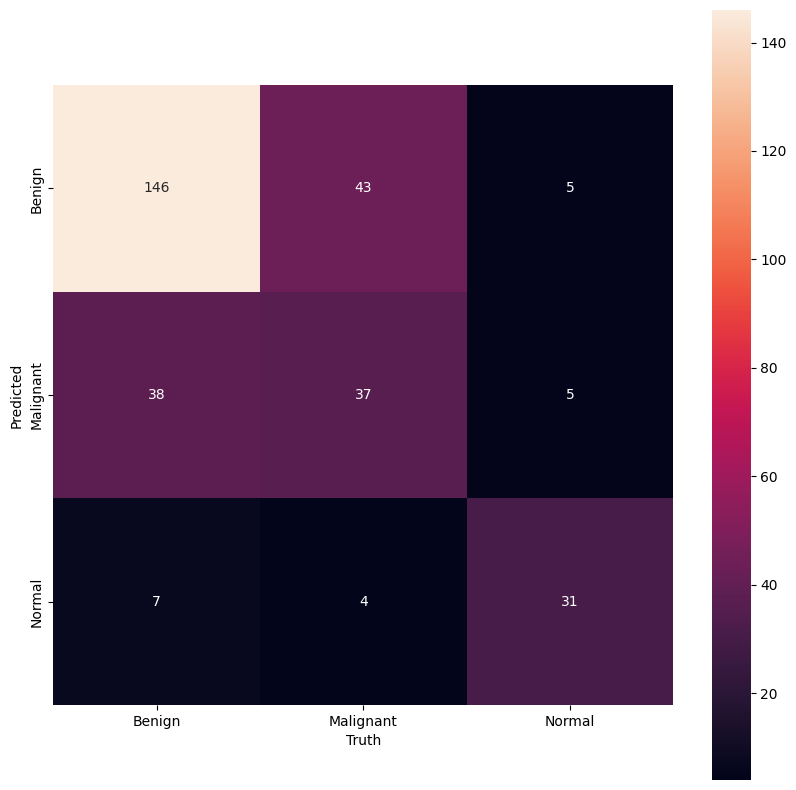

In [55]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_true, y_pred_sequential)
_=sns.heatmap(cm.T, annot=True, fmt='d', cbar=True, square=True, xticklabels=target_name.keys(),
             yticklabels=target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# Xception model

## Model

In [27]:
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(80, 80, 3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)

model = Sequential()
model.add(xception_model)
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20867627 (79.60 MB)
Trainable params: 20813099 (79.40 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = 20,
    validation_data = (X_val, y_val),
    )

Epoch 1/20
4/4 [==============================] - 70s 15s/step - loss: 0.8685 - accuracy: 0.5825 - val_loss: 0.8857 - val_accuracy: 0.5506
Epoch 2/20
4/4 [==============================] - 61s 15s/step - loss: 0.6457 - accuracy: 0.6892 - val_loss: 1.1943 - val_accuracy: 0.6487
Epoch 3/20
4/4 [==============================] - 62s 15s/step - loss: 0.4637 - accuracy: 0.7252 - val_loss: 2.1788 - val_accuracy: 0.6456
Epoch 4/20
4/4 [==============================] - 63s 16s/step - loss: 0.3908 - accuracy: 0.7907 - val_loss: 4.8318 - val_accuracy: 0.6108
Epoch 5/20
4/4 [==============================] - 63s 16s/step - loss: 0.2748 - accuracy: 0.8890 - val_loss: 5.8471 - val_accuracy: 0.6203
Epoch 6/20
4/4 [==============================] - 64s 16s/step - loss: 0.1661 - accuracy: 0.9651 - val_loss: 6.3062 - val_accuracy: 0.6139
Epoch 7/20
4/4 [==============================] - 63s 16s/step - loss: 0.1133 - accuracy: 0.9831 - val_loss: 4.4844 - val_accuracy: 0.6456
Epoch 8/20
4/4 [===========

## Predictions

In [29]:
y_pred_xception = np.argmax(model.predict(X_test, batch_size = 1), axis = 1)
y_true = [np.argmax(y, axis = None, out = None) for y in y_test]

316/316 [==============================] - 11s 33ms/step


## Classification report

In [30]:
print('Classification Report')
print(classification_report(y_true, y_pred_xception, target_names = target_name.keys()))

Classification Report
              precision    recall  f1-score   support

      Benign       0.91      0.32      0.47       191
   Malignant       0.70      0.56      0.62        84
      Normal       0.21      0.95      0.35        41

    accuracy                           0.47       316
   macro avg       0.61      0.61      0.48       316
weighted avg       0.76      0.47      0.50       316



## Confusion Matrix

Text(95.72222222222221, 0.5, 'Predicted')

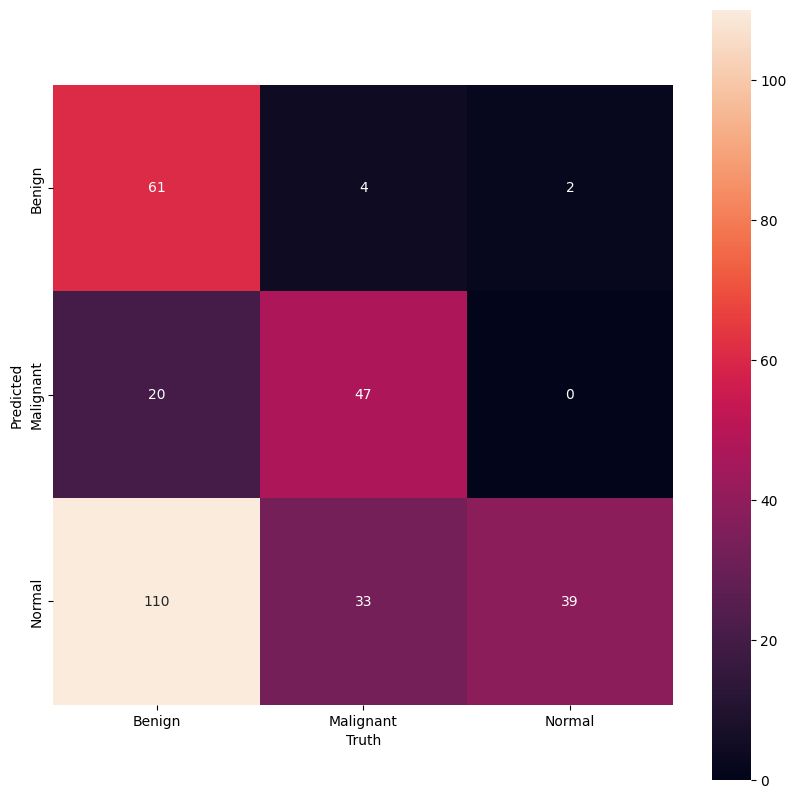

In [31]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_true, y_pred_xception)
_=sns.heatmap(cm.T, annot=True, fmt='d', cbar=True, square=True, xticklabels=target_name.keys(),
             yticklabels=target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# ResNet50V2

## Model

In [32]:
input_shape = (80, 80, 3)

resnet_model = ResNet50V2(
    weights = 'imagenet',
    input_shape = input_shape,
    classifier_activation = "softmax",
    include_top = False
)

for layer in resnet_model.layers:
    layer.trainable = True
    
model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 23827459 (90.89 MB)
Trainable params: 23782019 (90.72 MB)
Non-trainable params: 45440 (177.50 KB)
________

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = 30,
    validation_data = (X_val, y_val))
    #callbacks = callback


Epoch 1/30
4/4 [==============================] - 58s 12s/step - loss: 0.8976 - accuracy: 0.5973 - val_loss: 10.1067 - val_accuracy: 0.5506
Epoch 2/30
4/4 [==============================] - 49s 12s/step - loss: 0.4259 - accuracy: 0.8351 - val_loss: 14.5745 - val_accuracy: 0.5475
Epoch 3/30
4/4 [==============================] - 47s 12s/step - loss: 0.2098 - accuracy: 0.9207 - val_loss: 29.5136 - val_accuracy: 0.5443
Epoch 4/30
4/4 [==============================] - 47s 11s/step - loss: 0.1006 - accuracy: 0.9641 - val_loss: 32.7096 - val_accuracy: 0.5443
Epoch 5/30
4/4 [==============================] - 47s 12s/step - loss: 0.1117 - accuracy: 0.9672 - val_loss: 41.2490 - val_accuracy: 0.5443
Epoch 6/30
4/4 [==============================] - 47s 11s/step - loss: 0.0905 - accuracy: 0.9715 - val_loss: 38.6735 - val_accuracy: 0.5443
Epoch 7/30
4/4 [==============================] - 47s 12s/step - loss: 0.0889 - accuracy: 0.9715 - val_loss: 31.5776 - val_accuracy: 0.5443
Epoch 8/30
4/4 [====

## Predictions

In [34]:
y_pred_resnet = np.argmax(model.predict(X_test, batch_size = 1), axis = 1)
y_true = [np.argmax(y, axis = None, out = None) for y in y_test]

316/316 [==============================] - 8s 23ms/step


## Classification Report

In [35]:
print('Classification Report')
print(classification_report(y_true, y_pred_resnet, target_names = target_name.keys()))

Classification Report
              precision    recall  f1-score   support

      Benign       0.87      0.86      0.87       191
   Malignant       0.82      0.65      0.73        84
      Normal       0.63      0.90      0.74        41

    accuracy                           0.81       316
   macro avg       0.77      0.81      0.78       316
weighted avg       0.82      0.81      0.81       316



## Confusion Matrix

Text(95.72222222222221, 0.5, 'Predicted')

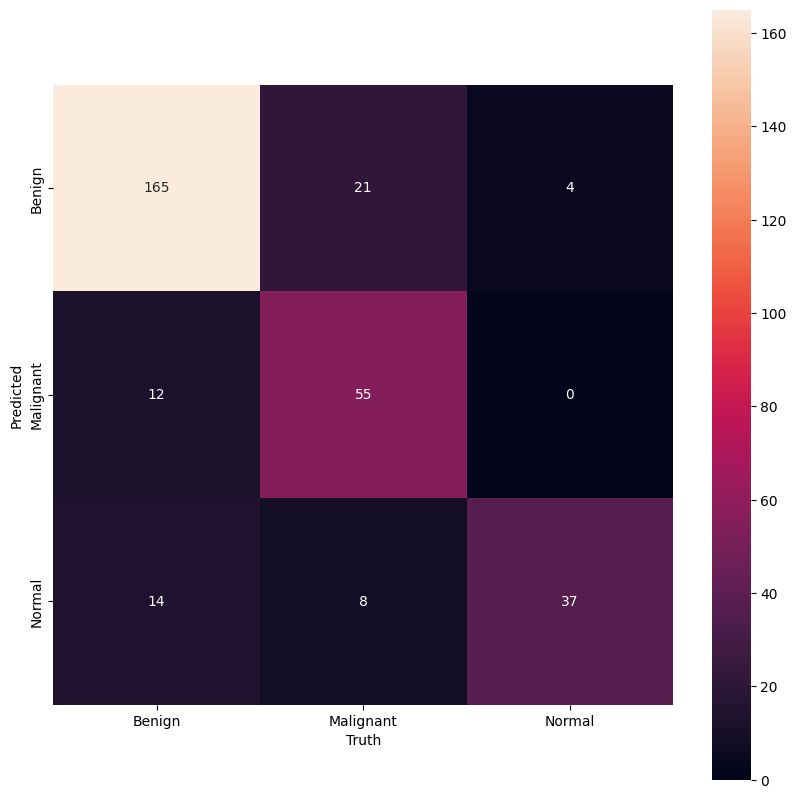

In [36]:
cm = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize = (10,10))
_ = sns.heatmap(cm.T, annot = True, fmt = 'd', cbar = True, square = True, xticklabels = target_name.keys(),
             yticklabels = target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# Conclusion

In conclusion, our ResNet50V2 model did much better than our Xception model and performed fairly well. 

Our Xception model suffers from a lot of confusion when trying to detect a normal image which is very problematic considering this is a medical problematic.

Finally, our Conv2D model had some confusion between benign and malignant images.